# How does a neural net really work? 

Exploring a basic neural net to get an intuition of how it works. 

This current notebook adapted from the following sources:  
- [Jeremy Howard's kaggle notebook: How does a neural net really work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)  
- [fastai book Chapter 4: Under the Hood: Training a Digit Classifier](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)  

## What is a neural network? 

[A neural network consists of interconnected nodes (neurons/nodes/units) which process and transmit data through a series of connections.](https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/)  

The generic layered architecture of a neural network can be divided into 3 different types:  
- input layer (receives input data and passes it on to the subsequent layer)  
- hidden layer (does most of the computation)
- output layer (receives output from the hidden layers, conducts the final computation and produces the final output of the network)  

See below for the structure of a typical neural network - source: https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/

![Structure of a typical neural network - source: https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/](https://www.deep-mind.org/wp-content/ql-cache/quicklatex.com-832dc2ccf282c799fa68d8c211646900_l3.svg)

### [What happens in one layer?]((https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)

In the simplest of neural networks, the neural network is just a mathematical function. For one layer, the function will perform the following basic steps:  

1. Multiplies each input by a number of parameters,  
2. Adds them up for each group of parameters,  
3. Replaces the negative numbers with zero (if using Rectified Linear Unit as the activation function)  

The 3 steps are then repeated using the outputs of the previous layers as the inputs to the next layer.  

The initial parameters are selected randomly, and then updated using an optimization algorithm such as stochastic gradient descent, using a loss function (to calculate how good the model is) and a predetermined learning rate. 

## What is an optimization algorithm? 

The are many optimization algorithms available that are meant for certain problems. [There is no reason to prefer one algorithm over another unless we make assumptions about the probability distribution over the space of possible objective functions.](https://books.google.com.sg/books?hl=en&lr=&id=uBSMDwAAQBAJ&oi=fnd&pg=PR7&dq=algorithms+for+optimization&ots=sxZU0plyMF&sig=d9xWr8KEwcF1e9WEzgronSCYU4U&redir_esc=y#v=onepage&q=algorithms%20for%20optimization&f=false) For many optimization algorithms to work effectively, there needs to be some regularity in the objective function, such as Lipschitz continuity or convexity. Each algorithm would have their own assumptions, motivations for their mechanism and their advantages and disadvantages.

**What is gradient descent?**

Gradient descent is an [iterative first-order optimization algorithm used to find a local minimum/maximum of a given function](https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21). The requirements are that the function has to be:  
- differentiable (i.e. it has a derivative for each point in its domain)  
- convex 

For more information: 
- [3 blue 1 brown: Gradient descent, how neural networks learn](https://www.3blue1brown.com/lessons/gradient-descent)
- https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21

### [intuition: How can we fit a function with gradient descent?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work) 

To get to the intuition behind gradient descent, let's start with a simple function - a quadratic function.

In [1]:
# libraries
from functools import partial
from ipywidgets import interact
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from typing import Callable
from typing import Tuple

In [2]:
def plot_function(
    f: Callable,
    title: str = None,
    min: float = -2.1,
    max: float = 2.1,
    color: str = 'r',
    ylim: Tuple = None
) -> plt.Figure:
    """Create a simple plot of a generic function"""
    
    x = torch.linspace(min, max, 100)
    if ylim:
        plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None:
        plt.title(title)

In [3]:
def quadratic_function(
    a: float, 
    b: float, 
    c: float, 
    x: float
)-> Callable: 
    """Define a quadratic function"""
    return a*x**2 + b*x + c
    
def make_quadratic(
    a: float,
    b: float,
    c: float
)-> Callable:
    """Create a generic quadratic function by passing in values for the parameters a,b,c"""
    return partial(quadratic_function, a, b, c)

In [4]:
# simulate some noisy data 
def noise(x, scale):
    return np.random.normal(scale=scale, size=x.shape)

def add_noise(x, multiply, add):
    return x*(1+noise(x,multiply))+noise(x, add)

np.random.seed(42)
def f(x): return 3*x**2 + 2*x + 1 #'true' function
x = torch.linspace(-2,2,steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

Here's some simulated data below. **How can we fit or find the optimal parameters for a function using gradient descent?** 

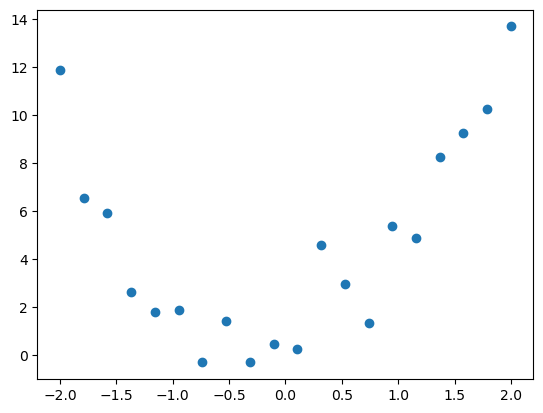

In [5]:
# visualize the simulated data
plt.scatter(x,y);

Before we can find the 'best' fit, we also need to quantify what we mean by model fit.   

A way of quantifying this would be to measure the distance from the model/curve to the data points. To ensure that negative distances do not cancel out the positive distances, we find the absolute of this distance, and then we find the mean of all the absolute distance values.  

This is known as the mean absolute error (MAE), which is mean of the absolute distance from each data point to the model/curve.  
This is our loss function for our current use case.  

The 'best' fit would be a model with parameters that have the lowest value for MAE. 

In [6]:
def mae(
    predicted: list, 
    true: list
)-> float:
    """calculate mean absolute error based on predicted and true values"""
    return (torch.abs(predicted-true)).mean()

#### Manual method

This is a method based on visually eye-balling the fit and the displayed mean absolute error associated with manual changes in the parameter values of the quadratic function.  
Although this is rudimentary, it is useful in giving us a basic intuition as to what we are trying to achieve in fitting a model to a dataset. 

In [7]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quadratic(a,b,c):
    f = make_quadratic(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x),y)
    plot_function(
        f,
        ylim=(-3,13),
        title=f"Mean Absolute Error: {loss:.2f}"
    )

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

#### [Automating gradient descent](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)

[Intuition](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work): if we know the gradient of our `mae()` function (loss function) *with respect to* our parameters `a`, `b`, `c`, then we have a way of adjusting the parameters. i.e. if `a` has a negative gradient, then increasing `a` will decrease `mae()`. 

We would first need a function that takes in the parameters `a`, `b`, `c` as a single vector input, an returns the value of `mae()` based on those parameters. 

In [8]:
def quadratic_mae(params: list, y)-> float:
    """Return the mean absolute error for a generic quadratic function a*x^2 + b*x + c based on an input list of 3 parmeters"""
    f = make_quadratic(*params)
    return mae(f(x), y)

We will use `PyTorch` to calculate the gradients for the parameters, and repeat this 10 times to see what effect this has on the loss/ mean absolute error. 
Note that we're also using a learning rate of 0.01 to start off with.  
- if we pick a learning rate that is too low, we would need to do a lot of steps to minimize the loss. 

![low learning rate](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_small.svg)

- on the other hand, if we pick a learning rate that is too high. it can actually result in the loss getting worse as seen in the following illustrations:

learning rate that is too high:  
![high learning rate](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_div.svg)  
![other consequence of high learning rate](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/chapter2_bouncy.svg)

In [9]:
learning_rate = 0.01 
abc = torch.randn(3) # random initial parameters
abc.requires_grad_() # tell pytorch to calculate gradients for these parameters 

for i in range(20):
    loss = quadratic_mae(abc,y)
    loss.backward() # get pytorch to calculate gradients
    with torch.no_grad(): # dont calculate gradients for this as abc.grad*learning_rate is not part of the quadratic model 
        abc -= abc.grad*learning_rate # optimizer step
    print(f"step:{i}; loss={loss:.2f}")

step:0; loss=7.55
step:1; loss=7.52
step:2; loss=7.46
step:3; loss=7.36
step:4; loss=7.24
step:5; loss=7.08
step:6; loss=6.89
step:7; loss=6.67
step:8; loss=6.41
step:9; loss=6.13
step:10; loss=5.83
step:11; loss=5.49
step:12; loss=5.15
step:13; loss=4.79
step:14; loss=4.41
step:15; loss=4.02
step:16; loss=3.61
step:17; loss=3.20
step:18; loss=2.78
step:19; loss=2.34


In [10]:
abc

tensor([1.3156, 1.8769, 1.5930], requires_grad=True)

Note that in this simple example above, we did not split the dataset into a training set, validation set and test set - we just used all of the values for our simulated 'y' to calculate the loss. In a more practical setting, however, the [optimization step would involve mini-batches instead using the training dataset](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb). We'd also monitor our performance metrics (in this case the MAE of the validation set) during this process. 

**Why use mini-batches?**   
Calculating the loss for the whole dataset would take a very long time, while calculating it for a single data item would result in a very imprecise and unstable gradient. The compromise is to use mini-batches;  
- larger batch sizes would result in a more accurate and stable estimate of the dataset's gradient from the loss function,  
- but it will take longer and we will process fewer mini-batches per epoch. 
Also, we would randomly shuffle our dataset for each epoch, before we create the mini-batches. 

#### [Summary of steps involved in gradient descent](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

1. Initialize the parameters to random values.  
2. Calculate the predictions.  
3. Calculate the loss.  
4. Calculate the gradients (i.e. an approximation of how the parameters need to change)  
5. Step the weights (i.e. update the parameters based on the calculated gradients)  
6. Repeat the process  
7. Stop the epochs - watch the training and validation losses and our performance metrics to decide when to stop. 

So now we know how gradient descent works to help us to automatically adjust the parameters of the function based on the existing data. But how can a neural network approximate any given function? see below:

### How can a neural net approximate any given function?

A neural network can approximate any computable function, given enough parameters - this is implied by the Universal approximation theorem.

Let's look at a simple [activation function (a functional that is applied to an intermediary output of a neuron) that allow it to model nonlinear relationships between the input and output data](https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/). 

#### [ReLU function](https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/)
The rectified linear unit function maps any negative input to 0 and any positive input to itsef. The definition is as follows:

![](https://www.deep-mind.org/wp-content/ql-cache/quicklatex.com-932b7b22111361835105b9ceb79c0ee1_l3.svg)  
source: https://www.deep-mind.org/2023/03/26/the-universal-approximation-theorem/

[So, how does the recified linear function work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)

In [11]:
def rectified_linear(
    weight: float,
    bias: float,
    x: list
)-> Callable:
    """create rectified linear unit function"""
    y = weight*x+bias
    return torch.clip(y, 0.) # alternatively it can be just F.relu(weight*x+bias)

@interact(weight=1.5, bias=1.5)
def plot_relu(weight, bias):
    plot_function(partial(rectified_linear, weight, bias),ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='weight', max=4.5, min=-1.5), FloatSlider(value=1.5, …

But the magic happens when you combine the rectified linear functions together, as seen below:

In [12]:
def double_relu(
    weight1:float,
    bias1:float,
    weight2:float,
    bias2: float,
    x
)-> Callable:
    return rectified_linear(weight1, bias1,x) + rectified_linear(weight2, bias2, x)

@interact(weight1=-1.5, bias1=-1.5, weight2=1.5, bias2=1.5)
def plot_double_relu(weight1, bias1, weight2, bias2):
    plot_function(partial(double_relu, weight1, bias1, weight2, bias2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='weight1', max=1.5, min=-4.5), FloatSlider(value=-1.…

Let's try a triple relu:

In [13]:
def triple_relu(
    weight1:float,
    bias1:float,
    weight2:float,
    bias2: float,
    weight3: float,
    bias3: float,
    x
)-> Callable:
    return rectified_linear(weight1, bias1,x) + rectified_linear(weight2, bias2, x) + rectified_linear(weight3, bias3, x)

@interact(weight1=-1.5, bias1=-1.5, weight2=1.5, bias2=1.5, weight3=1.5, bias3=1.5)
def plot_double_relu(weight1, bias1, weight2, bias2, weight3, bias3):
    plot_function(partial(triple_relu, weight1, bias1, weight2, bias2, weight3, bias3), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='weight1', max=1.5, min=-4.5), FloatSlider(value=-1.…

[With enough of these rectified linear functions added together, you could approximate any function with a single input to whatevery accuracy you like.](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)

### [Simple net from scratch](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

In this very basic neural network, we have a non-linear function (ReLU function) between 2 linear models (without an optimizer)

In [14]:
def simple_net(xb:torch.FloatTensor)-> Callable:
    """basic neural net"""
    res = xb@weight1 + bias1 # linear model
    res = res.max(tensor(0.0)) # rectified linear unit 
    res = res@weight2 + bias2
    setattr(res, "params", {'weight1':weight1, 'bias1':bias1, 'weight2':weight2, 'bias2':bias2})
    return res

`@`: matrix multiplication   

the dot product betwen the first matrix row and the the second matrix column can be visualized as below:  
![](https://raw.githubusercontent.com/fastai/fastbook/823b69e00aa1e1c1a45fe88bd346f11e8f89c1ff//images/matmul2.svg)  
source: https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb  

or from [3 Blue 1 Brown: Matrix Multiplication](https://www.3blue1brown.com/lessons/matrix-multiplication)